* **Course:** ARTI 502 – Deep Learning

* **Instructor:** Dr.  Noor Felemban

* **Section:** 2

* **Group:** 5

* **Date:** 14 December 2025


# **Dataset Preprocessing**

Dataset Link: "https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones"

## Imports + GPU Check:

In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow: 2.19.0
GPUs Available: 1


## Upload and Unzip UCI HAR Dataset:

In [ ]:

from google.colab import files
uploaded = files.upload()   # Upload the official "UCI HAR Dataset.zip"

Saving human+activity+recognition+using+smartphones.zip to human+activity+recognition+using+smartphones.zip


In [ ]:
!unzip -q "human+activity+recognition+using+smartphones.zip"

# Check extraction
!ls -R "human+activity+recognition+using+smartphones.zip"


human+activity+recognition+using+smartphones.zip


In [ ]:
!unzip -q "UCI HAR Dataset.zip"

human+activity+recognition+using+smartphones.zip


In [ ]:
# Check extraction
!ls -R "UCI HAR Dataset"

'UCI HAR Dataset':
activity_labels.txt  features_info.txt	features.txt  README.txt  test	train

'UCI HAR Dataset/test':
'Inertial Signals'   subject_test.txt   X_test.txt   y_test.txt

'UCI HAR Dataset/test/Inertial Signals':
body_acc_x_test.txt  body_gyro_x_test.txt  total_acc_x_test.txt
body_acc_y_test.txt  body_gyro_y_test.txt  total_acc_y_test.txt
body_acc_z_test.txt  body_gyro_z_test.txt  total_acc_z_test.txt

'UCI HAR Dataset/train':
'Inertial Signals'   subject_train.txt	 X_train.txt   y_train.txt

'UCI HAR Dataset/train/Inertial Signals':
body_acc_x_train.txt  body_gyro_x_train.txt  total_acc_x_train.txt
body_acc_y_train.txt  body_gyro_y_train.txt  total_acc_y_train.txt
body_acc_z_train.txt  body_gyro_z_train.txt  total_acc_z_train.txt


## Define Helper Function to Load Raw Signals:

In [ ]:
def load_signal(file_path):
    """
    Loads a raw inertial signal text file.
    Each file has shape: (samples, 128 timesteps)
    Returns a NumPy array of shape (samples, 128)
    """
    return np.loadtxt(file_path)

## Load ALL 9 Raw Signals (Accelerometer + Gyroscope):

In [ ]:
BASE_PATH = "UCI HAR Dataset"

SIGNALS = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"
]

def load_split(split="train"):
    """
    Loads the 9-channel inertial signals for train or test.
    Returns X: (N, 128, 9), y: integer labels, subjects
    """
    signal_path = f"{BASE_PATH}/{split}/Inertial Signals/"
    data = []

    for signal in SIGNALS:
        file = f"{signal_path}{signal}_{split}.txt"
        data.append(load_signal(file))

    # Stack into (samples, timesteps, channels)
    X = np.transpose(np.array(data), (1, 2, 0))

    # Load labels
    y = np.loadtxt(f"{BASE_PATH}/{split}/y_{split}.txt").astype(int)

    # Load subject IDs
    subjects = np.loadtxt(f"{BASE_PATH}/{split}/subject_{split}.txt").astype(int)

    return X, y, subjects

# Load train and test
X_train_raw, y_train_raw, subject_train = load_split("train")
X_test_raw,  y_test_raw,  subject_test  = load_split("test")

print("Train shape:", X_train_raw.shape)
print("Test shape:", X_test_raw.shape)

Train shape: (7352, 128, 9)
Test shape: (2947, 128, 9)


## Normalize Each Channel:

Raw sensor data must be normalized per channel, NOT per sample.

In [ ]:
#Normalize Each Sensor Channel Separately

# Reshape for channel-wise normalization
X_train_norm = X_train_raw.reshape(-1, 9)
X_test_norm  = X_test_raw.reshape(-1, 9)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train_norm)
X_test_norm  = scaler.transform(X_test_norm)

# Reshape back to (samples, 128, 9)
X_train = X_train_norm.reshape(X_train_raw.shape)
X_test  = X_test_norm.reshape(X_test_raw.shape)

print("Normalized shapes:", X_train.shape, X_test.shape)


Normalized shapes: (7352, 128, 9) (2947, 128, 9)


## One-Hot Encode Labels (Activities 1–6 → 0–5):

In [ ]:
# Labels range from 1–6 → convert to 0–5
y_train_int = y_train_raw - 1
y_test_int  = y_test_raw - 1

#Converts labels like "5" (Standing) into [0, 0, 0, 0, 0, 1].
#This allows the model to predict probability percentages for each class.
y_train = to_categorical(y_train_int, 6)
y_test  = to_categorical(y_test_int, 6)

print("y_train shape:", y_train.shape)

y_train shape: (7352, 6)


## SUBJECT-WISE VAL SPLIT:

In [ ]:
#This cell moves all data from Persons 1, 3, 5, and 7 into a separate pile (X_val).
#The model never sees these people while learning.
#This ensures our accuracy score is honest.
unique_subjects = sorted(np.unique(subject_train))
print("Subjects in train:", unique_subjects)

# 15% of subjects for validation
val_subjects = [1, 3, 5, 7]

train_mask = ~np.isin(subject_train, val_subjects)
val_mask   =  np.isin(subject_train, val_subjects)

X_train_sub = X_train[train_mask]
y_train_sub = y_train[train_mask]

X_val_sub = X_train[val_mask]
y_val_sub = y_train[val_mask]

print("Train:", X_train_sub.shape)
print("Val:  ", X_val_sub.shape)
print("Test: ", X_test.shape)


Subjects in train: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(11), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30)]
Train: (6054, 128, 9)
Val:   (1298, 128, 9)
Test:  (2947, 128, 9)


# **Proposed: Dual-Stream ResNet**

## Frequency Feature Extraction (FFT)

In [ ]:
import numpy as np

def calculate_fft(X):
    # Perform Fast Fourier Transform along the time axis (axis 1)
    # We take the absolute value (magnitude) to get the energy at each frequency
    #It looks at the wave-forms in your sensor data and breaks
    # them down into sine waves of different frequencies.
    #Why? Activities like walking or running have a strong rhythmic frequency (cadence).
    #Sitting has zero frequency. This helps the model distinguish between rhythmic and static activities.
    fft_features = np.abs(np.fft.fft(X, axis=1))
    return fft_features

# Create the Frequency (Spectral) Data
# the numbers now represent Frequency Energy instead of Sensor Amplitude.
print("Generating FFT features...")
X_train_fft = calculate_fft(X_train_sub)
X_val_fft   = calculate_fft(X_val_sub)
X_test_fft  = calculate_fft(X_test)

print(f"Original Shape: {X_train_sub.shape}")
print(f"FFT Data Shape: {X_train_fft.shape}") # Should be (N, 128, 9)

Generating FFT features...
Original Shape: (6054, 128, 9)
FFT Data Shape: (6054, 128, 9)


## Custom Attention Layer
What it does: This layer allows the Neural Network to "focus" on the specific parts of the signal that are most important, rather than treating every millisecond as equal.

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
      # Create a trainable weight matrix (W) and bias (b)
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros")
        super().build(input_shape)

    def call(self, x):
        # 1. Calculate scores for every time step using the tanh activation function.
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        # 2. Calculate weights (probabilities)
        # (e.g., "Time step 5 is 10% important, Time step 50 is 90% important").
        a = tf.keras.backend.softmax(e, axis=1)
        # 3. Apply weights to input
        output = x * a
        # 4. Sum up to get a single vector per sample
        return tf.keras.backend.sum(output, axis=1)


## The Dual-Stream Model Architecture
Dual-Stream (looks at two types of data at once).

In [ ]:
from tensorflow.keras import layers, models, optimizers, regularizers

def build_dual_stream_model_robust(input_shape=(128, 9), num_classes=6):

    # Shield 1: L2 Regularization (The "Leash")
    # Forces weights to be small, preventing the model from memorizing outliers.
    reg = regularizers.l2(0.001)

    #**=== STREAM 1: Temporal (Time-Series) ===
    input_time = layers.Input(shape=input_shape, name='time_input')

    # Shield 2: Stronger Noise
    # Increased from 0.01 to 0.05 so the model can't trust exact values
    x1 = layers.GaussianNoise(0.05)(input_time)

    # ResNet Block with L2 Regularization
    res = layers.Conv1D(64, 1, padding='same', kernel_regularizer=reg)(x1)

    x1 = layers.Conv1D(64, 5, activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=reg)(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.SpatialDropout1D(0.2)(x1) # Increased Dropout

    x1 = layers.Conv1D(64, 5, activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=reg)(x1)
    x1 = layers.BatchNormalization()(x1)

    #skip connections) to extract features
    x1 = layers.Add()([x1, res])
    x1 = layers.MaxPooling1D(2)(x1)

    # BiLSTM
    #to understand time/sequence
    x1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0))(x1) # Increased Dropout to 0.5
    x1 = layers.LayerNormalization()(x1)
    #to summarize
    x1 = Attention()(x1)

    #**=== STREAM 2: Spectral (Frequency) ===
    # A simpler CNN path that looks at the FFT data we created in Block 1.
    #It extracts rhythmic patterns.
    input_freq = layers.Input(shape=input_shape, name='freq_input')

    x2 = layers.Conv1D(64, 3, activation='swish', padding='same', kernel_regularizer=reg)(input_freq)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling1D(2)(x2)
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(64, activation='swish', kernel_regularizer=reg)(x2)
    x2 = layers.Dropout(0.5)(x2) # Increased Dropout to 0.5

    # === FUSION ===
    #Merges the "Time Understanding" and "Frequency Understanding"
    #into one big feature vector before making the final decision.
    merged = layers.Concatenate()([x1, x2])

    # Shield 3: High Dropout at the End
    m = layers.Dense(64, activation='swish', kernel_regularizer=reg)(merged)
    m = layers.Dropout(0.5)(m) # 50% of neurons are dropped every pass!

    outputs = layers.Dense(num_classes, activation='softmax')(m)

    model = models.Model(inputs=[input_time, input_freq], outputs=outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Re-build and Re-train
dual_model = build_dual_stream_model_robust()

## Callbacks
What it does: These tools watch the training process live and adjust settings automatically.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_list_robust = [
    EarlyStopping(
        monitor='val_loss', #Watches the Validation Loss
        patience=5, # If the loss doesn't improve for 5 epochs in a row, it stops training.
        restore_best_weights=True, # CRITICAL: This ensures you get the "Epoch 6" model, not the "Epoch 18" garbage.
        verbose=1
    ),
    #If the model gets stuck (accuracy stops going up), this divides the Learning Rate by 2 (factor=0.5).
    #This allows the model to take tinier, more precise steps to find the answer.
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [ ]:
history_dual = dual_model.fit(
    x=[X_train_sub, X_train_fft],  # <--- TWO INPUTS HERE? we must feed it a list of two datasets.
    y=y_train_sub,
    validation_data=([X_val_sub, X_val_fft], y_val_sub),
    epochs=60,
    batch_size=64,
    callbacks=callbacks_list_robust, # Use the same callbacks as before
    verbose=1
)

Epoch 1/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6316 - loss: 1.5055 - val_accuracy: 0.9253 - val_loss: 0.6526 - learning_rate: 5.0000e-04
Epoch 2/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9002 - loss: 0.7732 - val_accuracy: 0.9492 - val_loss: 0.5835 - learning_rate: 5.0000e-04
Epoch 3/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9251 - loss: 0.6455 - val_accuracy: 0.9515 - val_loss: 0.5405 - learning_rate: 5.0000e-04
Epoch 4/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9415 - loss: 0.5743 - val_accuracy: 0.9530 - val_loss: 0.5219 - learning_rate: 5.0000e-04
Epoch 5/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9415 - loss: 0.5438 - val_accuracy: 0.9584 - val_loss: 0.4909 - learning_rate: 5.0000e-04
Epoch 6/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9485 - loss: 0.4929 - val_accuracy: 0.9476 - val_loss: 0.4737 - learning_rate: 5.0000e-04
Epoch 7/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9479

In [ ]:
# 1. Get Final Training & Validation Accuracy from history
train_acc = history_dual.history['accuracy'][-1]
val_acc = history_dual.history['val_accuracy'][-1]

# 2. Evaluate on Test Data
test_loss, test_acc = dual_model.evaluate([X_test, X_test_fft], y_test, verbose=0)

print("-" * 40)
print(f"FINAL RESULTS")
print("-" * 40)
print(f"✔ Training Accuracy:   {train_acc * 100:.2f}%")
print(f"✔ Validation Accuracy: {val_acc * 100:.2f}%")
print(f"✔ Test Accuracy:       {test_acc * 100:.2f}%")
print("-" * 40)

----------------------------------------
FINAL RESULTS
----------------------------------------
✔ Training Accuracy:   99.24%
✔ Validation Accuracy: 95.38%
✔ Test Accuracy:       96.00%
----------------------------------------


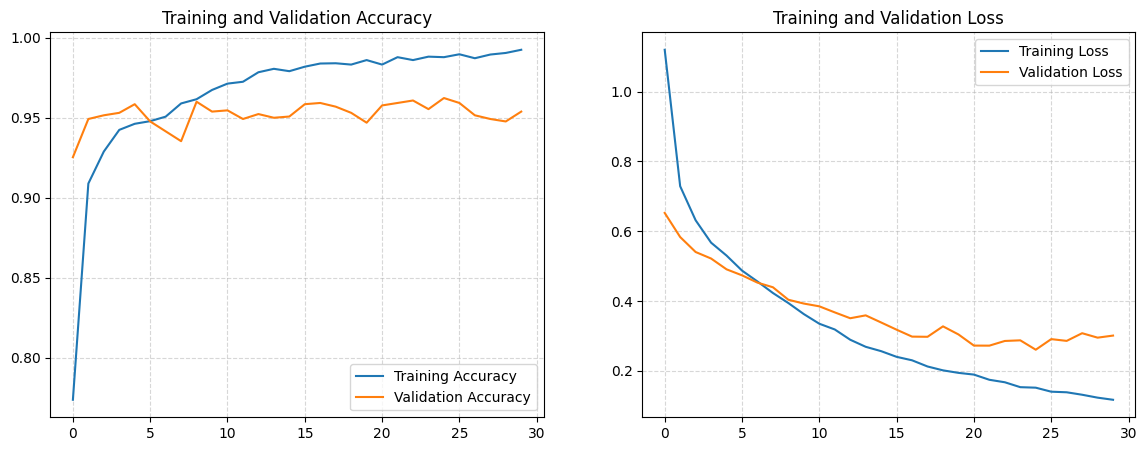

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

📊 DETAILED CLASSIFICATION REPORT:

              precision    recall  f1-score   support

     Walking     0.9880    0.9919    0.9899       496
     Walk Up     0.9749    0.9915    0.9832       471
   Walk Down     0.9976    0.9762    0.9868       420
     Sitting     0.9393    0.8513    0.8932       491
    Standing     0.8752    0.9492    0.9107       532
      Laying     1.0000    1.0000    1.0000       537

    accuracy                         0.9600      2947
   macro avg     0.9625    0.9600    0.9606      2947
weighted avg     0.9610    0.9600    0.9598      2947



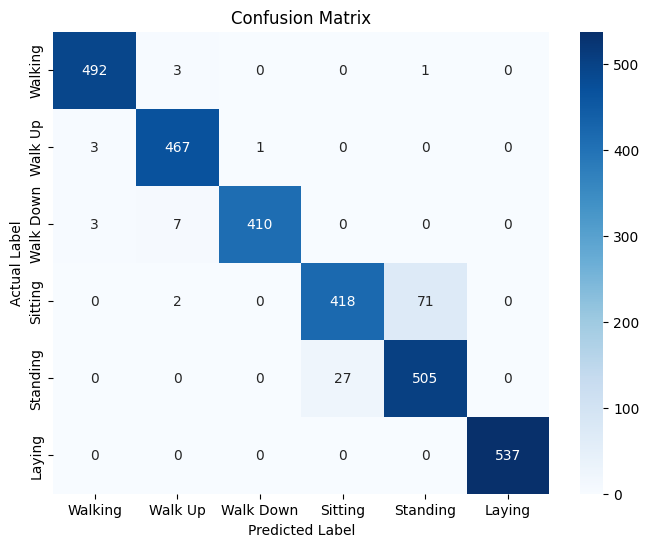

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- 1. Plot Training History (Loss & Accuracy) ---
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()

plot_training_history(history_dual)

# --- 2. Generate Predictions ---
# Get probabilities
y_pred_probs = dual_model.predict([X_test, X_test_fft])
# Convert probabilities to class integers (0, 1, 2...)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
# Convert one-hot true labels back to integers
y_true = np.argmax(y_test, axis=1)

# --- 3. Classification Report (Precision, Recall, F1) ---
# Standard UCI HAR Labels
class_labels = ['Walking', 'Walk Up', 'Walk Down', 'Sitting', 'Standing', 'Laying']

print("\n📊 DETAILED CLASSIFICATION REPORT:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4))

# --- 4. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# **BASE 1: CNN MODEL**

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
GLOBAL_SEED = 42

import os, random
import numpy as np
import torch

os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

torch.manual_seed(GLOBAL_SEED)
torch.cuda.manual_seed_all(GLOBAL_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
g = torch.Generator()
g.manual_seed(GLOBAL_SEED)

## Builed CNN


In [ ]:
class SimpleCNN1D(nn.Module):
  def __init__(self, num_classes=6, in_channels=9):
    super(SimpleCNN1D, self).__init__()

    self.conv1 = nn.Conv1d(in_channels, 8, kernel_size=5, padding=2)
    self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv1d(8, 16, kernel_size=5, padding=2)

    self.flatten_size = 16 * 32
    self.fc1 = nn.Linear(self.flatten_size,16)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(16, num_classes)

  def forward (self, x):
    x = torch.relu(self.conv1(x))
    x = self.pool(x)

    x = torch.relu(self.conv2(x))
    x = self.pool(x)

    x = x.view(x.size(0),-1)
    x= torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

##Prepare Data for PyTorch

In [ ]:
# Transpose Input
X_train_pt=np.transpose(X_train_sub,(0,2,1))
X_val_pt=np.transpose(X_val_sub,(0,2,1))
X_test_pt=np.transpose(X_test,(0,2,1))

# Convert Labels
y_train_pt=np.argmax(y_train_sub,axis=1)
y_val_pt=np.argmax(y_val_sub,axis=1)
y_test_pt=np.argmax(y_test,axis=1)

# Create TensorDatasets
train_dataset=TensorDataset(torch.Tensor(X_train_pt),torch.LongTensor(y_train_pt))
val_dataset=TensorDataset(torch.Tensor(X_val_pt),torch.LongTensor(y_val_pt))
test_dataset=TensorDataset(torch.Tensor(X_test_pt),torch.LongTensor(y_test_pt))

# Create DataLoaders
BATCH_SIZE=32
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,generator=g)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

##Training

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model=SimpleCNN1D(num_classes=6,in_channels=9).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005,weight_decay=5e-2)

def training(model,loader):
  model.train()
  running_loss=0.0
  correct=0.0
  total=0.0

  for inputs, labels in loader:
    inputs, labels = inputs.to(device),labels.to(device)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+= (predicted ==labels).sum().item()
  return running_loss/len(loader),100* correct/total

Using device: cuda


##Evaluate

In [ ]:
def evaluate(model,loader):
  model.eval()
  correct=0
  total=0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs, labels = inputs.to(device),labels.to(device)
      outputs=model(inputs)
      _,predicted=torch.max(outputs.data,1)
      total+=labels.size(0)
      correct+= (predicted ==labels).sum().item()
    return 100* correct/total

In [ ]:
def evaluate_loss(model, loader):
    model.eval()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

##Metrics

In [ ]:
def all_metrics(model,loader):
  model.eval()
  all_preds=[]
  all_labels=[]
  with torch.no_grad():
    for inputs, labels in loader:
      inputs, labels = inputs.to(device),labels.to(device)
      outputs=model(inputs)
      _,predicted=torch.max(outputs.data,1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

##Train CNN

In [ ]:
EPOCHS = 15
train_losses = []
train_accuracies = []
val_accuracies = []
val_losses = []

print("\nTraining..")
for epoch in range(EPOCHS):

    train_loss, train_acc = training(model, train_loader)
    val_acc = evaluate(model, val_loader)
    val_loss = evaluate_loss(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train acc: {train_acc:.2f}% | "
          f"Loss: {train_loss:.4f} | "
          f"Val acc: {val_acc:.2f}% | "
          f"Val loss: {val_loss:.4f}")

best_epoch = val_accuracies.index(max(val_accuracies)) + 1
print(f"\nBest Epoch: {best_epoch} with Val Acc = {max(val_accuracies):.2f}%")

torch.save(model.state_dict(), "simple1D-CNN.pth")
print("\nModel saved as simple1D-CNN.pth")



Training..
Epoch 1/15 | Train acc: 51.95% | Loss: 1.2163 | Val acc: 70.11% | Val loss: 0.7279
Epoch 2/15 | Train acc: 74.28% | Loss: 0.6086 | Val acc: 76.89% | Val loss: 0.4972
Epoch 3/15 | Train acc: 80.97% | Loss: 0.4604 | Val acc: 85.82% | Val loss: 0.4192
Epoch 4/15 | Train acc: 87.36% | Loss: 0.3617 | Val acc: 88.83% | Val loss: 0.3257
Epoch 5/15 | Train acc: 89.71% | Loss: 0.3104 | Val acc: 91.06% | Val loss: 0.2762
Epoch 6/15 | Train acc: 90.83% | Loss: 0.2799 | Val acc: 91.06% | Val loss: 0.2628
Epoch 7/15 | Train acc: 91.10% | Loss: 0.2713 | Val acc: 90.45% | Val loss: 0.2582
Epoch 8/15 | Train acc: 91.59% | Loss: 0.2527 | Val acc: 90.83% | Val loss: 0.2376
Epoch 9/15 | Train acc: 91.54% | Loss: 0.2539 | Val acc: 90.83% | Val loss: 0.2486
Epoch 10/15 | Train acc: 91.91% | Loss: 0.2510 | Val acc: 92.14% | Val loss: 0.2301
Epoch 11/15 | Train acc: 91.92% | Loss: 0.2401 | Val acc: 93.07% | Val loss: 0.2287
Epoch 12/15 | Train acc: 91.97% | Loss: 0.2415 | Val acc: 92.22% | Val lo

In [ ]:
# FINAL TRAIN accuracy
train_acc = train_accuracies[-1]
print(f"✔ CNN Final Training Accuracy: {train_acc:.2f}%")

# FINAL VALIDATION accuracy
val_acc = val_accuracies[-1]
print(f"✔ CNN Final Validation Accuracy: {val_acc:.2f}%")

# TEST ACCURACY (BEST MODEL)
best_model = SimpleCNN1D()   # change to your model class
best_model.load_state_dict(torch.load("simple1D-CNN.pth"))
best_model.to(device)
best_model.eval()

test_acc = evaluate(best_model, test_loader)
print(f"✔ CNN Test Accuracy (Best Model): {test_acc:.2f}%")


✔ CNN Final Training Accuracy: 92.65%
✔ CNN Final Validation Accuracy: 91.53%
✔ CNN Test Accuracy (Best Model): 87.58%


##Evaluate on the Official Test Set

In [ ]:
print("\nEvaluating on official Test Set")

test_acc = evaluate(model, test_loader)
print(f"✔ CNN Test Accuracy (Final Model): {test_acc:.2f}%")

y_true, y_pred = all_metrics(model, test_loader)


class_names = ["WALK","UP","DOWN","SIT","STAND","LAY"]

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=2,
    zero_division=0
))

## per calss accuracy

cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for name, acc_value in zip(class_names, class_accuracy):
    print(f"{name}: {acc_value*100:.2f}%")



Evaluating on official Test Set
✔ CNN Test Accuracy (Final Model): 87.58%

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

        WALK       0.90      0.90      0.90       496
          UP       0.83      0.95      0.88       471
        DOWN       0.95      0.79      0.86       420
         SIT       0.85      0.71      0.77       491
       STAND       0.77      0.88      0.82       532
         LAY       1.00      1.00      1.00       537

    accuracy                           0.88      2947
   macro avg       0.88      0.87      0.87      2947
weighted avg       0.88      0.88      0.87      2947

WALK: 90.12%
UP: 95.33%
DOWN: 79.05%
SIT: 71.28%
STAND: 87.59%
LAY: 100.00%


##Plotting CNN Results

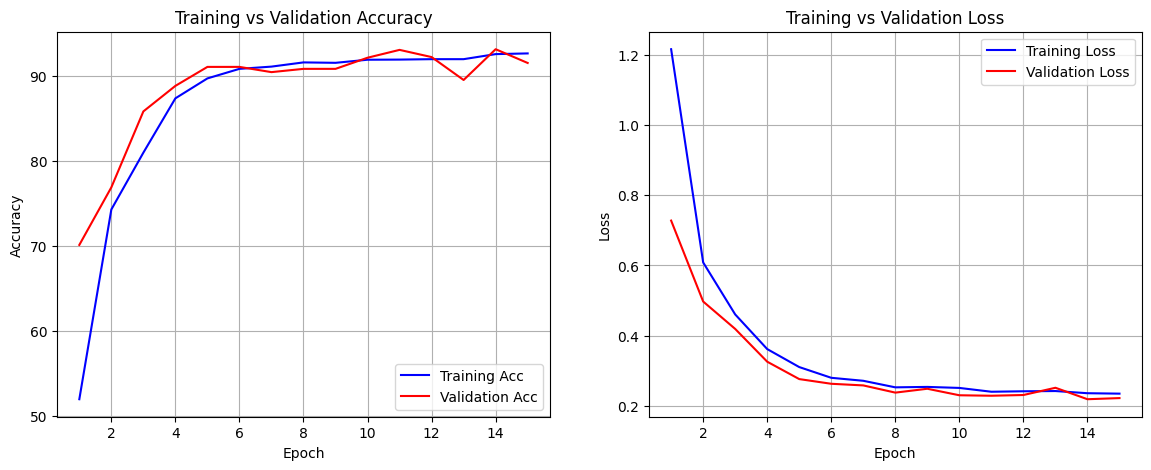

In [ ]:
def plot_history_pytorch(train_accuracies, val_accuracies, train_losses, val_losses):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b', label='Training Acc')
    plt.plot(epochs, val_accuracies, 'r', label='Validation Acc')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.show()

# Call it:
plot_history_pytorch(train_accuracies, val_accuracies, train_losses, val_losses)



##Confusion Matrix

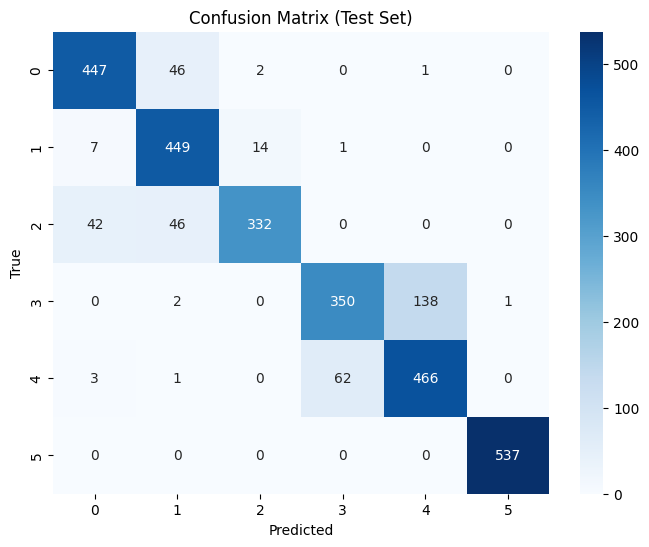

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# **BASE 2: CNN–LSTM MODEL**

## Create CNN–LSTM Model:


In [ ]:
# CNN–LSTM MODEL Architecture

from tensorflow.keras import layers, models, optimizers

def build_cnn_lstm(input_shape=(128, 9), num_classes=6):
    model = models.Sequential()

    # ----- CNN Block 1 -----
    # this It learns to recognize short patterns
    # such as a sudden spike in acceleration (a foot hitting the ground).
    model.add(layers.Conv1D(64, kernel_size=5, activation='relu', padding='same',
                            input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    #shrinks the data by half, keeping only the strongest signals. reduces calculation time.
    model.add(layers.MaxPooling1D(pool_size=2))

    # ----- CNN Block 2 -----
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    # ----- LSTM Layer -----
    #The "Memory"
    # It provides the context
    #(e.g., "This movement is rhythmic, so it's probably walking").
    model.add(layers.LSTM(64, return_sequences=False, dropout=0.3))

    # ----- Dense Layers -----
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))

    # ----- Output -----
    #Softmax: Converts numbers into probabilities
    #6 probabilities that sum to 1.0.
    model.add(layers.Dense(num_classes, activation='softmax'))

    # ----- Compile -----
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0007),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

cnn_lstm_model = build_cnn_lstm()
cnn_lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,174 (403.02 KB)

 Trainable params: 102,662 (401.02 KB)

 Non-trainable params: 512 (2.00 KB)

## Callbacks:
Why? To prevent overfitting and automatically tune the LR.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_cnn_lstm.keras',   # THIS IS CORRECT FOR MODEL #1
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


## Train CNN–LSTM:

In [ ]:
history_cnn_lstm = cnn_lstm_model.fit(
    X_train_sub, y_train_sub,
    validation_data=(X_val_sub, y_val_sub),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6450 - loss: 1.0187
Epoch 1: val_accuracy improved from -inf to 0.71032, saving model to best_cnn_lstm.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6465 - loss: 1.0148 - val_accuracy: 0.7103 - val_loss: 0.6998 - learning_rate: 7.0000e-04
Epoch 2/50
91/95 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9430 - loss: 0.1785
Epoch 2: val_accuracy improved from 0.71032 to 0.90293, saving model to best_cnn_lstm.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9430 - loss: 0.1780 - val_accuracy: 0.9029 - val_loss: 0.2844 - learning_rate: 7.0000e-04
Epoch 3/50
91/95 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9463 - loss: 0.1355
Epoch 3: val_accuracy improved from 0.90293 to 0.94299, saving model to best_cnn_lstm.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9464 - loss: 0.1353 - val_accuracy: 0.9430 - val_loss: 0.1533 - learning_rate: 7.0000e-04
Epoch 4/50
90/95 ━━━━━━━━━━━━━━━━━━━━ 0s 9

## EVALUATE ON OFFICIAL TEST SET:

In [ ]:
import tensorflow.keras as keras
# TRAIN accuracy (final epoch)
train_acc = history_cnn_lstm.history['accuracy'][-1]
print(f"✔ CNN–LSTM Test Accuracy Final Training Accuracy: {train_acc*100:.2f}%")

# VALIDATION accuracy (final epoch)
val_acc = history_cnn_lstm.history['val_accuracy'][-1]
print(f"✔ CNN–LSTM Test Accuracy Final Validation Accuracy: {val_acc*100:.2f}%")

# TEST accuracy using best saved model
best_model = keras.models.load_model("best_cnn_lstm.keras")
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
print(f"✔ CNN–LSTM Test Accuracy Test Accuracy (Best Model): {test_acc*100:.2f}%")

✔ CNN–LSTM Test Accuracy Final Training Accuracy: 96.27%
✔ CNN–LSTM Test Accuracy Final Validation Accuracy: 93.30%
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8801 - loss: 0.3969
✔ CNN–LSTM Test Accuracy Test Accuracy (Best Model): 92.09%


## Plotting CNN-LSTM

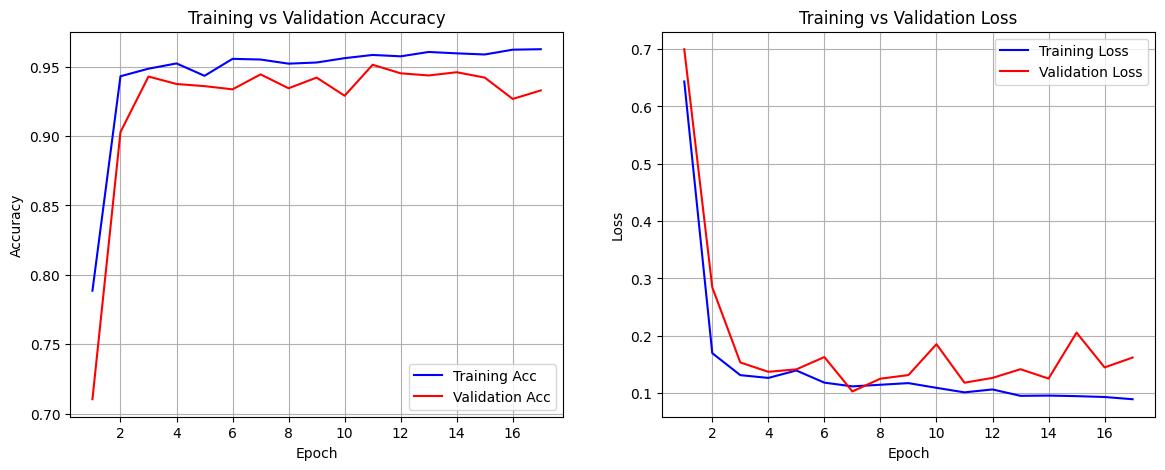

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


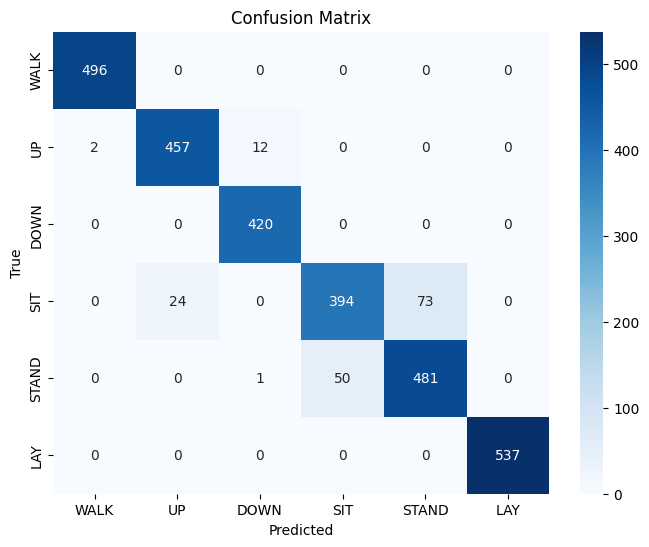


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

        WALK       1.00      1.00      1.00       496
          UP       0.95      0.97      0.96       471
        DOWN       0.97      1.00      0.98       420
         SIT       0.89      0.80      0.84       491
       STAND       0.87      0.90      0.89       532
         LAY       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.94      0.95      0.94      2947

WALK: 100.00%
UP: 97.03%
DOWN: 100.00%
SIT: 80.24%
STAND: 90.41%
LAY: 100.00%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# ======================================================
# 1) Plot Accuracy & Loss Curves
# ======================================================

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.show()

# Call it:
plot_history(history_cnn_lstm)



# ======================================================
# 2) Confusion Matrix
# ======================================================

y_pred = cnn_lstm_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["WALK","UP","DOWN","SIT","STAND","LAY"],
            yticklabels=["WALK","UP","DOWN","SIT","STAND","LAY"],
            cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



# ======================================================
# 3) Classification Report
# ======================================================

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(
    y_true_labels,
    y_pred_labels,
    target_names=["WALK","UP","DOWN","SIT","STAND","LAY"]
))



# ======================================================
# 4) Per-Class Accuracy Table
# ======================================================

class_accuracy = cm.diagonal() / cm.sum(axis=1)

for label, acc in zip(["WALK","UP","DOWN","SIT","STAND","LAY"], class_accuracy):
    print(f"{label}: {acc*100:.2f}%")
